In [4]:
%%capture
import sys; sys.path.append('../../..')

# Requires alpaca_trade_api backtrader matplotlib==3.2.2 plotly quantstats ta-lib (also requires talib C install)
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
import backtrader as bt
import matplotlib as mpl
import pytz
import datetime
from functools import lru_cache

import datetime

mpl.rcParams['figure.dpi'] = 250


API_KEY: str = ""
SECRET_KEY: str = ""
for l in open('../../../paper.env'):
    if l.startswith("APCA_API_KEY_ID="):
        API_KEY = l.split("=")[1].strip()
    elif l.startswith("APCA_API_SECRET_KEY="):
        SECRET_KEY = l.split("=")[1].strip()

assert API_KEY
assert SECRET_KEY

rest_api = REST(API_KEY, SECRET_KEY, 'https://paper-api.alpaca.markets')



def get_pandas_data(symbol, timeframe, start, end):
  alpaca_data = rest_api.get_bars(symbol, timeframe, start, end, adjustment='all').df
  alpaca_data.index = alpaca_data.index.tz_convert("America/New_York")

  if timeframe != TimeFrame.Day:
    alpaca_data = alpaca_data.between_time(datetime.time(9, 30), datetime.time(16, 0), include_end=False)

  return alpaca_data

@lru_cache()
def get_data(symbol, timeframe, start, end):
  alpaca_data = get_pandas_data(symbol, timeframe, start, end)
  data = bt.feeds.PandasData(dataname=alpaca_data, name=symbol, tz=pytz.timezone('US/Eastern'))
  return data

def run_backtest(strategy, symbol: str, start: str, end: str, params, timeframe=TimeFrame.Minute, cash=10000):
  cerebro = bt.Cerebro(stdstats=True)
  cerebro.broker.setcash(cash)
  cerebro.addstrategy(strategy, **params)
  cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
  cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
  cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")
  cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
  cerebro.adddata(get_data(symbol, timeframe, start, end))
 
  results = cerebro.run()

  cerebro.plot(iplot=True)

  strat = results[0]
  return strat

def get_roi(strategy):
  annual_returns = strategy.analyzers.annualreturn.get_analysis()
  r = 1
  for ret in annual_returns.values():
    r *= 1 + ret
  r -= 1
  return r

def get_max_drawdown(strategy):
  return strategy.analyzers.drawdown.get_analysis()['max']['drawdown']/100



In [5]:
dir(bt.ind)

['ADX',
 'ADXR',
 'AO',
 'APO',
 'ATR',
 'AbsPriceOsc',
 'AbsolutePriceOscillator',
 'AccDeOsc',
 'AccelerationDecelerationOscillator',
 'Accum',
 'AdaptiveMovingAverage',
 'AdaptiveMovingAverageEnvelope',
 'AdaptiveMovingAverageOsc',
 'AdaptiveMovingAverageOscillator',
 'All',
 'AllN',
 'And',
 'Any',
 'AnyN',
 'ApplyN',
 'ArithmeticMean',
 'AroonDown',
 'AroonIndicator',
 'AroonOsc',
 'AroonOscillator',
 'AroonUp',
 'AroonUpDown',
 'AroonUpDownOsc',
 'AroonUpDownOscillator',
 'Average',
 'AverageDirectionalMovementIndex',
 'AverageDirectionalMovementIndexRating',
 'AverageTrueRange',
 'AverageWeighted',
 'AwesomeOsc',
 'AwesomeOscillator',
 'BBands',
 'BaseApplyN',
 'BollingerBands',
 'BollingerBandsPct',
 'CCI',
 'Cmp',
 'CmpEx',
 'CointN',
 'CommodityChannelIndex',
 'CrossDown',
 'CrossOver',
 'CrossUp',
 'CumSum',
 'CumulativeSum',
 'DEMA',
 'DEMAEnvelope',
 'DEMAOsc',
 'DEMAOscillator',
 'DI',
 'DM',
 'DMA',
 'DMAEnvelope',
 'DMAOsc',
 'DMAOscillator',
 'DMI',
 'DPO',
 'DV2',
 'D

In [69]:
symbol = 'NRGU'
start = "2021-01-01"
end = "2022-05-29"
cash = 1000
timeframe = TimeFrame.Minute

In [70]:
class ChangedLevels(bt.Indicator):
  params = dict(
    level_divisor=20,
  )
  lines = ('current_level',)
  def __init__(self):
    pass
    # For some reason, this doesn't work (always gave 13.0?)
    # self.current_level = self.data.close // 20
  
  def next(self):
    self.current_level[0] = self.data.close[0] // self.p.level_divisor


class OnChange(bt.Indicator):
  lines = ('on_change',)
  def next(self):
    self.on_change[0] = self.data0[0] != self.data0[-1]

class MyStrategy(bt.Strategy):
    params = dict(
      level_divisor=20,
      take_profit_levels_up=2,
      stop_loss_levels_down=2,
    )

    def __init__(self):
      self.occupations = {}
      self.current_level = ChangedLevels(level_divisor=self.p.level_divisor)
      self.wakeup_signal = OnChange(self.current_level.current_level)

    def next(self):
      if self.wakeup_signal[0] and not self.occupations.get(self.current_level.current_level[0], False):
        new_level = self.current_level.current_level[0]
        old_level = self.current_level.current_level[-1]
        level_to_occupy = max(new_level, old_level)

        size = 1
        # TODO: some cleverness when issuing orders so when moving up we aren't selling and buying
        self.buy_bracket(size=size,
          limitprice=(level_to_occupy+self.p.take_profit_levels_up)*self.p.level_divisor,
          stopprice=(level_to_occupy-self.p.stop_loss_levels_down)*self.p.level_divisor,
          tradeid=level_to_occupy)
    
    def notify_order(self, order):
      if order.status in (bt.Order.Completed, bt.Order.Partial):
        if order.tradeid in self.occupations:
          self.occupations[order.tradeid]['size'] += order.executed.size
        else:
          self.occupations[order.tradeid] = {
            'size': order.executed.size,
          }
        
        # if position is wiped out, remove it from the dict
        if abs(self.occupations[order.tradeid]['size']) < 1:
          del self.occupations[order.tradeid]


# Detail

<IPython.core.display.Javascript object>

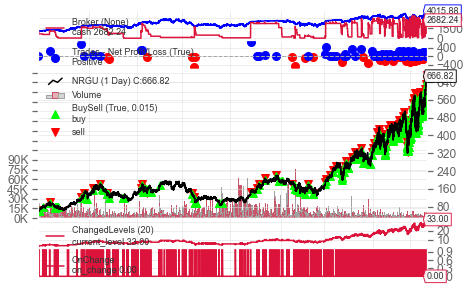

In [71]:
strategy = run_backtest(MyStrategy, symbol, start, end,
  {}
  , cash=cash, timeframe=timeframe
)

In [74]:
annual_returns = strategy.analyzers.annualreturn.get_analysis()
analysis = strategy.analyzers.tradeanalyzer.get_analysis()
# print(strategy.p.__dict__)
print(f"ROI     : {get_roi(strategy):.1%}")
print(f"Drawdown: {strategy.analyzers.drawdown.get_analysis()['max']['drawdown']/100:.1%}")
print(f"Average : {analysis['total']['total']} trades @ {analysis['pnl']['gross']['average']:.2f}")
print(f"Winners : {(analysis['won']['total'] / analysis['total']['total']):.1%} @ {analysis['won']['pnl']['average']:.2f}")
print(f"Losers  : {(analysis['lost']['total'] / analysis['total']['total']):.1%} @ {analysis['lost']['pnl']['average']:.2f}")

ROI     : 301.6%
Drawdown: 45.8%
Average : 126 trades @ 24.03
Winners : 61.1% @ 113.92
Losers  : 37.3% @ -123.25


In [75]:
import quantstats
portfolio_stats = strategy.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
quantstats.reports.basic(returns)

                    Strategy
------------------  ----------
Start Period        2021-01-04
End Period          2022-05-27
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   301.59%
CAGR﹪              171.53%

Sharpe              1.69
Sortino             2.62
Sortino/√2          1.85
Omega               1.34

Max Drawdown        -42.69%
Longest DD Days     218

Gain/Pain Ratio     0.34
Gain/Pain (1M)      3.16

Payoff Ratio        1.11
Profit Factor       1.34
Common Sense Ratio  1.64
CPC Index           0.81
Tail Ratio          1.22
Outlier Win Ratio   3.19
Outlier Loss Ratio  3.29

MTD                 42.49%
3M                  38.71%
6M                  72.21%
YTD                 88.79%
1Y                  77.89%
3Y (ann.)           171.53%
5Y (ann.)           171.53%
10Y (ann.)          171.53%
All-time (ann.)     171.53%

Avg. Drawdown       -8.45%
Avg. Drawdown Days  18
Recovery Factor     7.07
Ulcer Index         0.16
Serenity Index      2.86


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
from src.results import metadata, from_backtest
from src import types

transactions.index = transactions.index.tz_convert("America/New_York")
transactions['time'] = transactions.index

from_backtest.write_results("rungs", [types.FilledOrder(intention=None, symbol=t['symbol'], quantity=t['amount'], price=t['price'], datetime=t['time'].to_pydatetime()) for t in transactions.to_dict('records')], metadata.Metadata(commit_id="", last_updated=datetime.datetime.now()))

# Optimize

In [77]:
gridsearch = dict(
    level_divisor=[10, 15, 20, 25, 30, 40, 50, 60],
    take_profit_levels_up=[1, 2, 3],
    stop_loss_levels_down=[1, 2, 3, 4],
)

time_per = datetime.timedelta(seconds=10)

choices = 1
for l in gridsearch.values():
  choices *= len(l)

estimated_time = time_per * choices
print(f"Estimated time (@ {time_per}, {choices}): {estimated_time}")
start_time = datetime.datetime.now()
print(f"(ending at {start_time + (time_per * choices)})")
print("=" * 80)

cerebro = bt.Cerebro(stdstats=True, maxcpus=1)  # inside of VS Code editor, this does not go well
cerebro.broker.setcash(cash)
cerebro.optstrategy(MyStrategy, **gridsearch)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")
cerebro.adddata(get_data(symbol, timeframe, start, end))

runs = cerebro.run()
backtest_results = [results[0] for results in runs]



end_time = datetime.datetime.now()
print(f"Done. Took {end_time - start_time}")
print(f"time per: {(end_time - start_time) / choices}")

for strategy in list(sorted(backtest_results, key=get_roi, reverse=True))[:10]:
  analysis = strategy.analyzers.tradeanalyzer.get_analysis()
  if analysis["total"]["total"] == 0:
    continue
  annual_returns = strategy.analyzers.annualreturn.get_analysis()
  print(strategy.p.__dict__)
  print(f"ROI     : {get_roi(strategy):.1%}")
  print(f"Drawdown: {get_max_drawdown(strategy):.1%}")
  print(f"Average : {analysis['total']['total']} trades @ {analysis['pnl']['gross']['average']:.2f}")
  print(f"Winners : {(analysis['won']['total'] / analysis['total']['total']):.1%} @ {analysis['won']['pnl']['average']:.2f}")
  print(f"Losers  : {(analysis['lost']['total'] / analysis['total']['total']):.1%} @ {analysis['lost']['pnl']['average']:.2f}")
  print()

Estimated time (@ 0:00:10, 96): 0:16:00
(ending at 2022-05-30 23:52:50.723289)
